In [1]:
import torch
from torch import nn
import sys
sys.path.append('..')
import pandas as pd
from train_utils import load_signal_data, make_performance_uncertainty_plot, load_datasets
import os
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("paper")
sns.plotting_context("paper")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

In [2]:
train_data, test_data = load_datasets('../data/processed')

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(44, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


In [4]:
model = MLP()

In [5]:
from torch.utils import data

train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = data.DataLoader(test_data, batch_size=512, shuffle=False)

In [6]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/.0845]))


In [7]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 32
# 32

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs.squeeze(-1), labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())            
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            outputs = model(images)
            loss = loss_fn(outputs.squeeze(-1), labels)
            valid_losses.append(loss.item())
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses)))

epoch : 1, train loss : 0.8981, valid loss : 0.7639
epoch : 2, train loss : 0.7818, valid loss : 0.7487
epoch : 3, train loss : 0.7622, valid loss : 0.7762
epoch : 4, train loss : 0.7397, valid loss : 0.7473
epoch : 5, train loss : 0.7234, valid loss : 0.7343
epoch : 6, train loss : 0.7182, valid loss : 0.7151
epoch : 7, train loss : 0.7049, valid loss : 0.7638
epoch : 8, train loss : 0.6918, valid loss : 0.8022
epoch : 9, train loss : 0.6854, valid loss : 0.7313
epoch : 10, train loss : 0.6672, valid loss : 0.7126
epoch : 11, train loss : 0.6625, valid loss : 0.7099
epoch : 12, train loss : 0.6512, valid loss : 0.7037
epoch : 13, train loss : 0.6513, valid loss : 0.6989
epoch : 14, train loss : 0.6459, valid loss : 0.7388
epoch : 15, train loss : 0.6398, valid loss : 0.6987
epoch : 16, train loss : 0.6276, valid loss : 0.7013
epoch : 17, train loss : 0.6234, valid loss : 0.6775
epoch : 18, train loss : 0.6192, valid loss : 0.7024
epoch : 19, train loss : 0.6123, valid loss : 0.7580
ep

In [12]:
def predictive_entropy(y_):
    
    try: 
        y_ = y_.squeeze(-1)
        
    except:
        pass
        
    if y_.ndim == 2:
    
        return -(y_ * np.log2(y_ + 1e-9)).sum(-1)
    
    else:
        return -(y_ * np.log2(y_ + 1e-9) + ((1-y_) * np.log2(1 - y_ + 1e-9)))

In [13]:
train_data, train_labels, test_data, test_labels = load_signal_data('../data/processed/')

In [14]:
with torch.no_grad():
    predictions = torch.sigmoid(model(test_data).squeeze(-1)).numpy()

In [15]:
uncertainties = predictive_entropy(predictions)

In [16]:
X_train_raw, X_test_raw = (pd.read_csv('../data/processed/X_train_raw.csv'),
                          pd.read_csv('../data/processed/X_test_raw.csv'))

X_train_processed, X_test_processed = (pd.read_csv('../data/processed/X_train_processed.csv'),
                          pd.read_csv('../data/processed/X_test_processed.csv'))

In [17]:
mean_age = X_train_processed['age'].mean()

In [18]:
dataset_dir = '../data/processed/'

y_newborn = pd.read_csv(os.path.join(dataset_dir, 'y_newborns.csv'), squeeze=True)
X_newborn = pd.read_csv(os.path.join(dataset_dir, 'X_newborns.csv'))
X_newborn['age'] = mean_age

labels_newborn: torch.Tensor = torch.from_numpy(y_newborn.values)
data_newborn: torch.Tensor = torch.from_numpy(X_newborn.values).float()


In [19]:
with torch.no_grad():
    predictions_newborn = torch.sigmoid(model(data_newborn).squeeze(-1)).numpy()
    uncertainties_newborn = predictive_entropy(predictions_newborn)
    



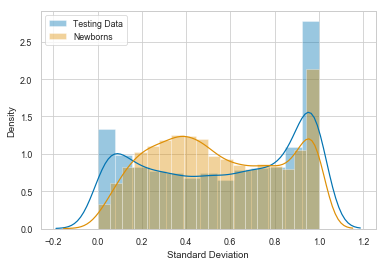

In [20]:
sns.distplot(uncertainties, label='Testing Data')
sns.distplot(uncertainties_newborn, label='Newborns')
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.legend()

In [21]:
uncertainties_newborn.mean() / uncertainties.mean()

0.97256243

In [22]:
data_random = torch.rand_like(data_newborn)
with torch.no_grad():
    predictions_random = torch.sigmoid(model(data_random).squeeze(-1)).numpy()

    uncertainties_random = predictive_entropy(predictions_random)



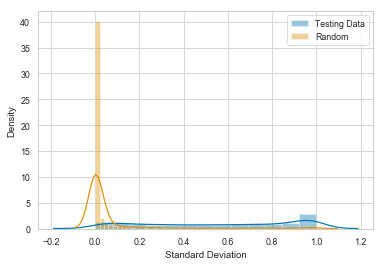

In [23]:
sns.distplot(uncertainties, label='Testing Data')
sns.distplot(uncertainties_random, label='Random')
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.legend()

In [24]:
uncertainties_random.mean() / uncertainties.mean()

0.101397045

# Detecting Incorrect Classifications

In [25]:

predictions_softmax = np.vstack(([1 - predictions, predictions])).T


succes_labels = np.zeros(len(predictions))
correct_predictions = predictions_softmax.argmax(-1) == test_labels.numpy()
succes_labels[correct_predictions] = 1

error_labels = 1 - succes_labels


In [26]:
roc_auc_score(succes_labels, predictions_softmax.max(-1))

0.7792252158010153

In [27]:
average_precision_score(succes_labels, predictions_softmax.max(-1))

0.9338000764706491

In [28]:
average_precision_score(error_labels, 1 - predictions_softmax.max(-1))

0.4187317024200051

In [29]:
roc_auc_score(error_labels, 1 - predictions_softmax.max(-1))

0.7792252158010153

# Detecting Out Of Domain

In [31]:
predictions_cat = np.concatenate((predictions, predictions_newborn))
predictions_cat_softmax = np.vstack(([1 - predictions_cat, predictions_cat])).T

In [32]:
in_domain = np.ones(len(predictions_cat))
in_domain[len(predictions_newborn):] = 0

out_domain = 1 - in_domain

In [33]:
roc_auc_score(in_domain, predictions_cat_softmax.max(-1))

0.48660415174916166

In [34]:
average_precision_score(in_domain, predictions_cat_softmax.max(-1))

0.586413620973285

In [35]:
average_precision_score(out_domain, predictions_cat_softmax.min(-1))

0.4263384194842073